In [11]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib import cm, colors
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default = "browser"

plt.style.use("article.mplstyle")

np.set_printoptions(formatter={'all': lambda x: "{:.4g}".format(x)})

In [2]:
from plot import *
from electric_field import *
from utils import *
from lattice import *
from computation import *
from dynamics import *

## Réflection sur le réseau à 10°

In [5]:
Na = 1100
Nd = 20
Rd = 9
a = 0.25
theta = np.deg2rad(10)
E0 = 1e-3
w0 = 4
detuning = 0
incident_field = GaussianBeam(E0, theta, w0)

d = periodicity_for_bragg_condition(theta)
disk_density = (Na/Nd)/(np.pi*(Rd**2)*a)

# print_param(Na, Nd, Rd, a, d, theta, disk_density)
save_param("output/full_disk/param.txt", Na, Nd, Rd, a, d, theta, disk_density, detuning, w0, E0)

I, x, z, scatterers = compute_mean_intensity(100, Na, Nd, Rd, d, a, incident_field, detuning)

np.save("output/full_disk/intensity.npy", I/E0**2)
np.save("output/full_disk/x.npy", x)
np.save("output/full_disk/z.npy", z)
np.save("output/full_disk/scatterers.npy", scatterers)

============= Paramètres =============
Nombre de diffuseurs : 1100, nombre de disques : 20
Rayon des disques : 9, epaisseur : 0.250
Distance entre les disques : 0.508, longueur du réseau : 9.65
Angle incidence : 10.00°
Densieé sans dimension des disques : 0.86


100%|██████████| 99/99 [11:11<00:00,  6.78s/it]


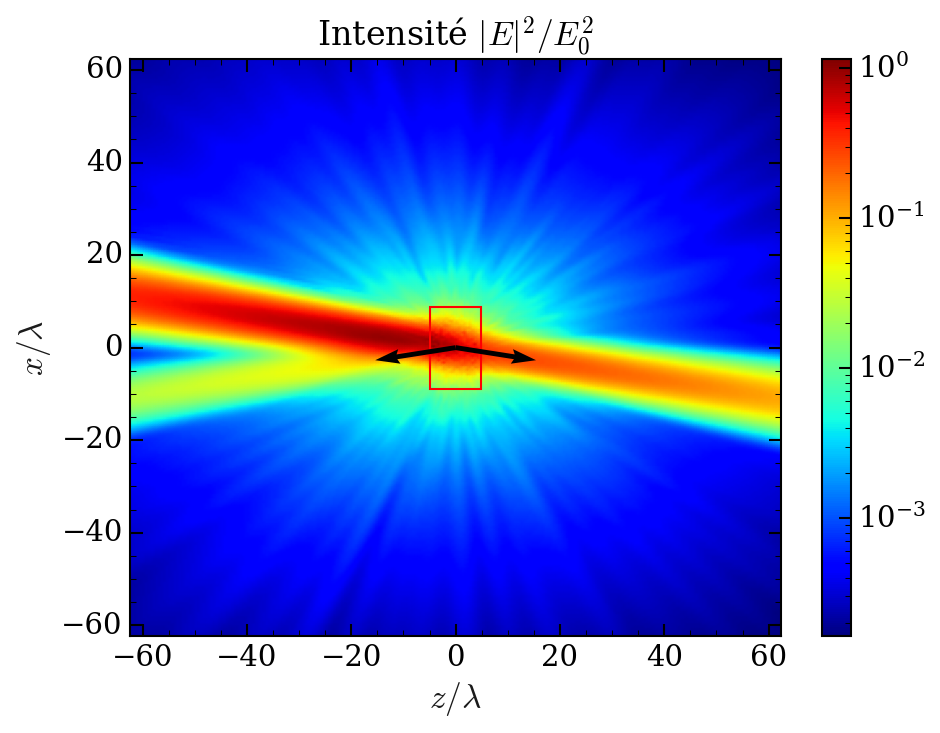

In [7]:
I = np.load("output/full_disk/intensity.npy")
x = np.load("output/full_disk/x.npy")
z = np.load("output/full_disk/z.npy")

show_intensity_xOz(I, x, z, scatterers,
                incident_field.k,
                bragg_direction(incident_field, d))

## Mise en avant du minimum dans la direction de Bragg par éclairement à 90°

In [8]:
# Minimum of intensity in bragg direction when light not in bragg direction

Na = 1100
Nd = 51
Rd = 9
a = 0.01
theta = np.deg2rad(90)
E0 = 1e-3
w0 = 4
detuning = 0.05
incident_field = GaussianBeam(E0, theta, w0)

d = periodicity_for_bragg_condition(np.deg2rad(45))
disk_density = (Na/Nd)/(np.pi*(Rd**2)*a)

# print_param(Na, Nd, Rd, a, d, theta, disk_density)
save_param("output/3D_data_gap/param.txt", Na, Nd, Rd, a, d, theta, disk_density, detuning, w0, E0)

I, x, y, z = compute_mean_angular_intensity(20, Na, Nd, Rd, d, a, detuning, incident_field, resolution=300, distance=200)

np.save("output/3D_data_gap/intensity.npy", I/E0**2)
np.save("output/3D_data_gap/x.npy", x)
np.save("output/3D_data_gap/y.npy", y)
np.save("output/3D_data_gap/z.npy", z)
np.save("output/3D_data_gap/scatterers.npy", scatterers)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:07<00:00,  9.37s/it]


In [12]:
I = np.load("output/3D_data_gap/intensity.npy")
x = np.load("output/3D_data_gap/x.npy")
y = np.load("output/3D_data_gap/y.npy")
z = np.load("output/3D_data_gap/z.npy")

show_intensity_3D_plotly(I, x, y, z, 200)

# Dynamique temporelle : poids des différents taux de décroissance sur l'état stationnaire

In [36]:
# ========= Eigenvalues for a specific configuration ==========
Na = 8000
Nd = 20
Rd = 9
a = 0.25
theta = np.deg2rad(10)
E0 = 1e-3
w0 = 4
detuning = 0
incident_field = GaussianBeam(E0, theta, w0)

d = periodicity_for_bragg_condition(theta)
disk_density = (Na/Nd)/(np.pi*(Rd**2)*a)

print_param(Na, Nd, Rd, a, d, theta, disk_density)

# ==========================================================

============= Paramètres =============
Nombre de diffuseurs : 8000, nombre de disques : 20
Rayon des disques : 9, epaisseur : 0.250
Distance entre les disques : 0.508, longueur du réseau : 9.65
Angle incidence : 10.00°
Densieé sans dimension des disques : 6.29


In [ ]:
def plot_eigenvalues(eigenvalues, decomposition):
    ith_vector = np.arange(len(eigenvalues))

    gs = GridSpec(2, 1, hspace=0)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0], sharex=ax1)

    ax1.bar(ith_vector, decomposition.flatten(), color="red")
    ax1.set_ylabel("$|\\langle u_i | \\Psi_{stat} \\rangle |^2$")

    ax2.plot(ith_vector, 2*np.real(eigenvalues).flatten(), color="red", marker="o", label="$\\Re (\\lambda_i)$")
    # ax2.plot(ith_vector, np.imag(eigenvalues).flatten(), color="blue", marker="o", label="$\\Im (\\lambda_i)$", markersize=3)
    ax2.set_xlabel("Numéro de l'état propre")
    ax2.legend(fancybox=False, framealpha=0)

    plt.tight_layout()
    plt.show()

ith_vector = np.arange(Na)
gs = GridSpec(2, 1, hspace=0)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0], sharex=ax1)

for i in tqdm(range(1)):
    scatterers = centered_optical_lattice(Na, Nd, Rd, d, a)
    amplitudes = excited_probabilities(scatterers, incident_field, detuning)

    M = compute_gamma_matrix(scatterers)
    M *= -0.5

    V, P = np.linalg.eig(M)

    decomposition = np.abs(np.dot(np.conjugate(P).T, amplitudes.reshape(-1, 1)))**2
    idx = np.argsort(-np.real(V), axis=0)
    V = V[idx]
    decomposition = decomposition[idx]

    ax1.bar(ith_vector, decomposition.flatten(), color="red")

    ax2.plot(ith_vector, 2*np.real(V).flatten(), color="red", marker="o", markersize=4)

ax1.set_ylabel("$|\\langle u_i | \\Psi_{stat} \\rangle |^2$")
ax2.set_xlabel("Numéro de l'état propre")
ax2.set_ylabel("$\\Gamma_i$")
ax2.hlines(-1, 0, Na, color="black", linestyle="--", label="Spontaneous emission rate")
ax2.legend(fancybox=False, framealpha=0)
plt.tight_layout()
plt.savefig("1100scat.png", dpi=300)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

# Dynamique : Taux de décroissance selon nombre d'atomes

n = 1
n = 51
n = 101
n = 151
n = 201
n = 251
n = 301
n = 351
n = 401
n = 451
n = 501
n = 551
n = 601
n = 651
n = 701
n = 751
n = 801
n = 851
n = 901
n = 951


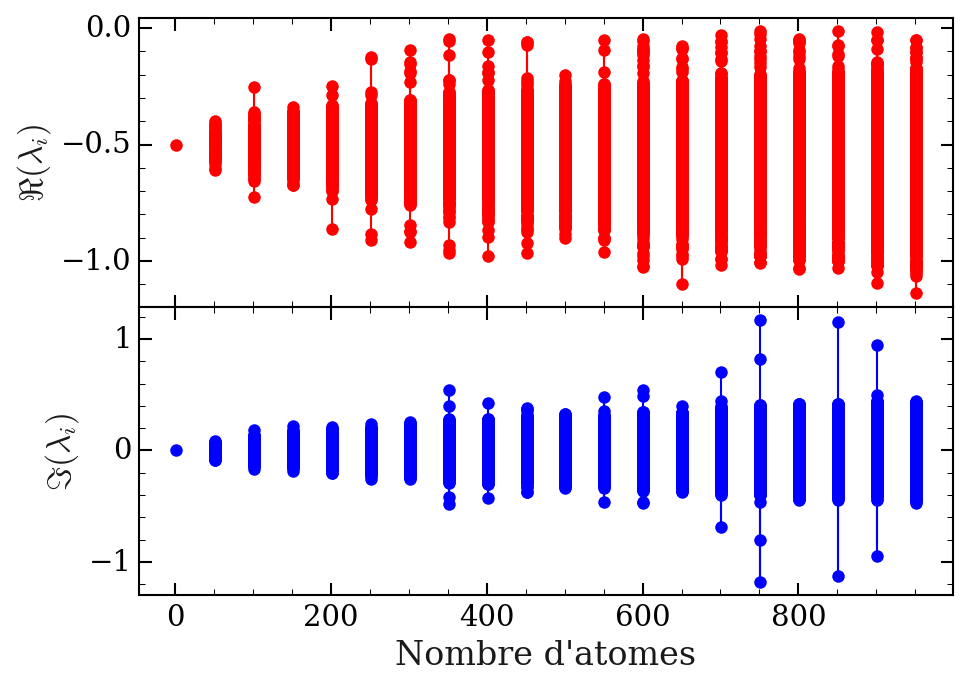

In [ ]:
# ============ Plotting eigenvalues in function of the number of scatterers ============
Na = 0
Nd = 20
Rd = 9
a = 0.25
theta = np.deg2rad(10)
E0 = 1e-3
w0 = 4
detuning = 0
incident_field = GaussianBeam(E0, theta, w0)

d = periodicity_for_bragg_condition(theta)
disk_density = (Na/Nd)/(np.pi*(Rd**2)*a)

Na = np.arange(1, 1000, 50)

gs = GridSpec(2, 1, hspace=0)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0], sharex=ax1)

for n in Na:
    scatterers = centered_optical_lattice(n, Nd, Rd, d, a)
    amplitudes = excited_probabilities(scatterers, incident_field, detuning)

    M = compute_gamma_matrix(scatterers)
    M *= -0.5

    t1, beta1, P, V = compute_time_evolution_exact_diagonalization(M, amplitudes)

    ax1.plot(n * np.ones(n), np.real(V).flatten(), color="red", marker="o")
    ax2.plot(n * np.ones(n), np.imag(V).flatten(), color="blue", marker="o")

ax2.set_ylabel("$\\Im (\\lambda_i)$")
ax1.set_ylabel("$\\Re (\\lambda_i)$")
ax2.set_xlabel("Nombre d'atomes")
plt.show()


## Taux de décroissance moyen selon le nombre d'atomes

n = 1
n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11
n = 12
n = 13
n = 14
n = 15
n = 16
n = 17
n = 18
n = 19
n = 20
n = 21
n = 22
n = 23
n = 24
n = 25
n = 26
n = 27
n = 28
n = 29
n = 30
n = 31
n = 32
n = 33
n = 34
n = 35
n = 36
n = 37
n = 38
n = 39
n = 40
n = 41
n = 42
n = 43
n = 44
n = 45
n = 46
n = 47
n = 48
n = 49


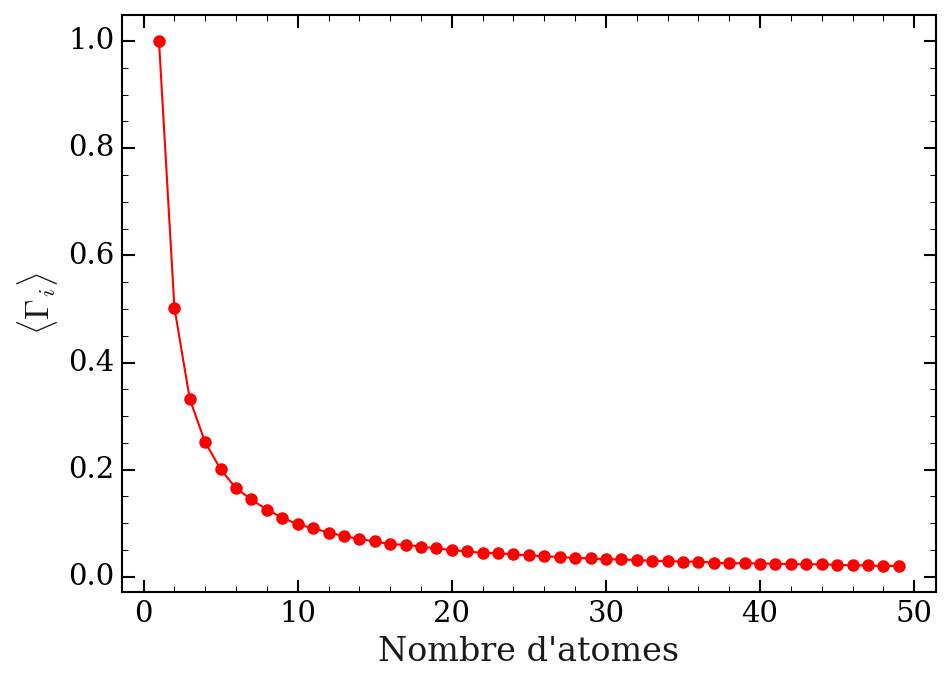

In [33]:
Na = 0
Nd = 20
Rd = 9
a = 0.25
theta = np.deg2rad(10)
E0 = 1e-3
w0 = 4
detuning = 0
incident_field = GaussianBeam(E0, theta, w0)

d = periodicity_for_bragg_condition(theta)
disk_density = (Na/Nd)/(np.pi*(Rd**2)*a)

Na = np.arange(1, 50, 1)

gs = GridSpec(1, 1, hspace=0)
ax1 = plt.subplot(gs[0, 0])

gamma = np.zeros_like(Na, dtype=np.float64)

for i, n in enumerate(Na):
    print(f"n = {n}")
    for j in range(2):
        scatterers = centered_optical_lattice(n, Nd, Rd, d, a)
        amplitudes = excited_probabilities(scatterers, incident_field, detuning)

        M = compute_gamma_matrix(scatterers)
        M *= -0.5

        V, P = np.linalg.eig(M)

        decomposition = np.abs(np.dot(np.conjugate(P).T, amplitudes.reshape(-1, 1)))**2
        gamma[i] -= 2 * np.mean(np.real(V).flatten() * decomposition.flatten()) / np.sum(np.abs(decomposition.flatten()))
    gamma[i] /= 2

ax1.plot(Na, gamma, color="red", marker="o")
ax1.set_ylabel("$\\langle \\Gamma_i \\rangle$")
ax1.set_xlabel("Nombre d'atomes")
plt.show()
